In [1]:
import numpy as np
import argparse
import os
import sys
import torch
import matplotlib.pyplot as plt
import json

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from utils import fft_denoise, wavelet_denoise, compute_metrics
from datasets import ECGDataset
from models import *

model_dict = {
    "UNet": UNet,
    "ACDAE": ACDAE,
    "Seq2Seq2": Seq2Seq2,
    "ralenet": ralenet,
    "DTUNet": DTUNet,
}

split_dir = "./data_split"

# 加载分割信息
split_path = os.path.join(split_dir, "split_info.json")
if not os.path.exists(split_path):
	raise FileNotFoundError(f"Split file not found: {split_path}")

with open(split_path, "r") as f:
	split_data = json.load(f)

# 加载数据文件
mean, std = split_data["clean_mean"], split_data["clean_std"]



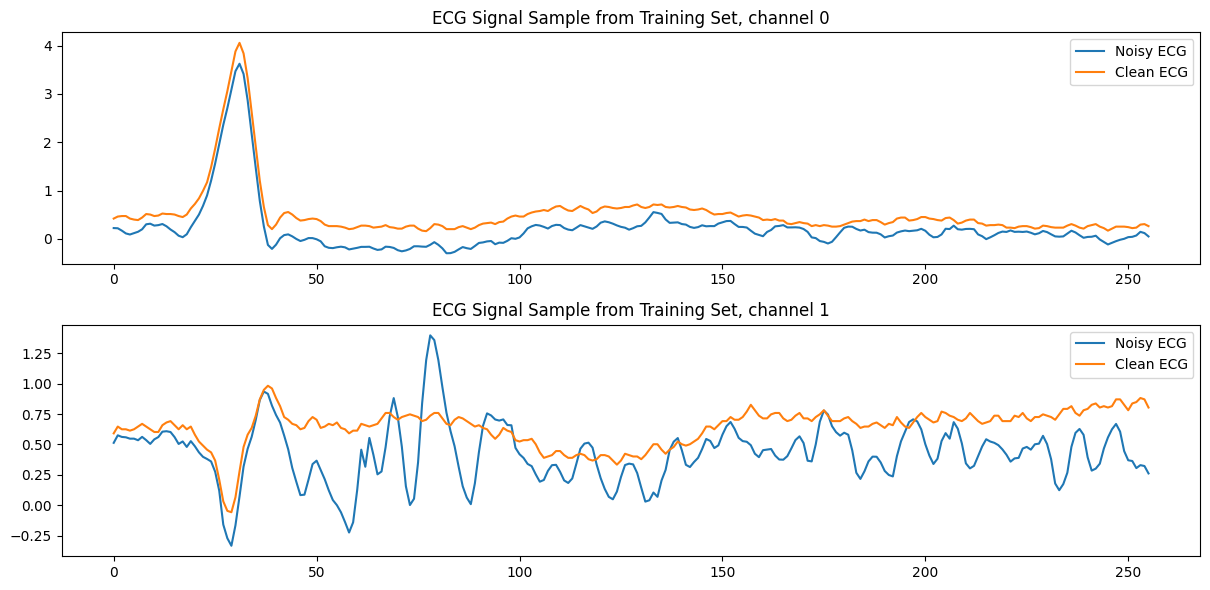

In [ ]:
model_name = "DTUNet"
noise_type = "emb"
snr_db = -4

dataset = ECGDataset(
	split="test",
	noise_type=noise_type,
	snr_db=snr_db,
	split_dir="./data_split",
)
idx = np.random.randint(0, len(dataset) - 1)
noisy, clean = dataset[idx]


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(noisy[0].numpy(), label="Noisy ECG")
plt.plot(clean[0].numpy(), label="Clean ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 0")

plt.subplot(2, 1, 2)
plt.plot(noisy[1].numpy(), label="Noisy ECG")
plt.plot(clean[1].numpy(), label="Clean ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 1")

plt.tight_layout()
plt.show()

DNN Denoising Metrics: {'RMSE': 0.1319609433412552, 'SNR': 5.296206951141357}
(2,) (2,)


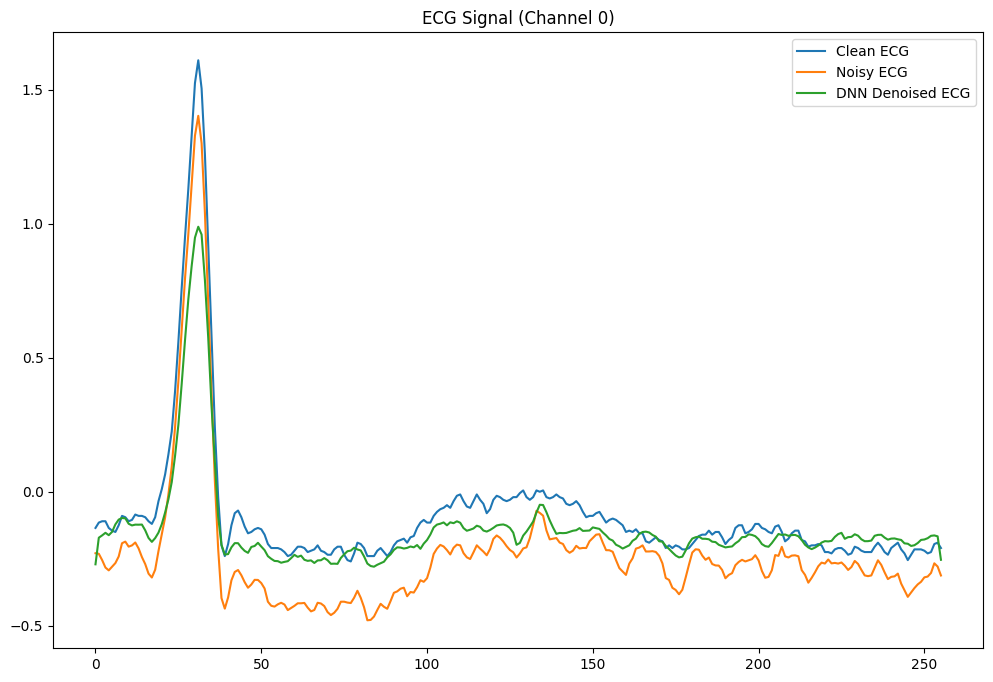

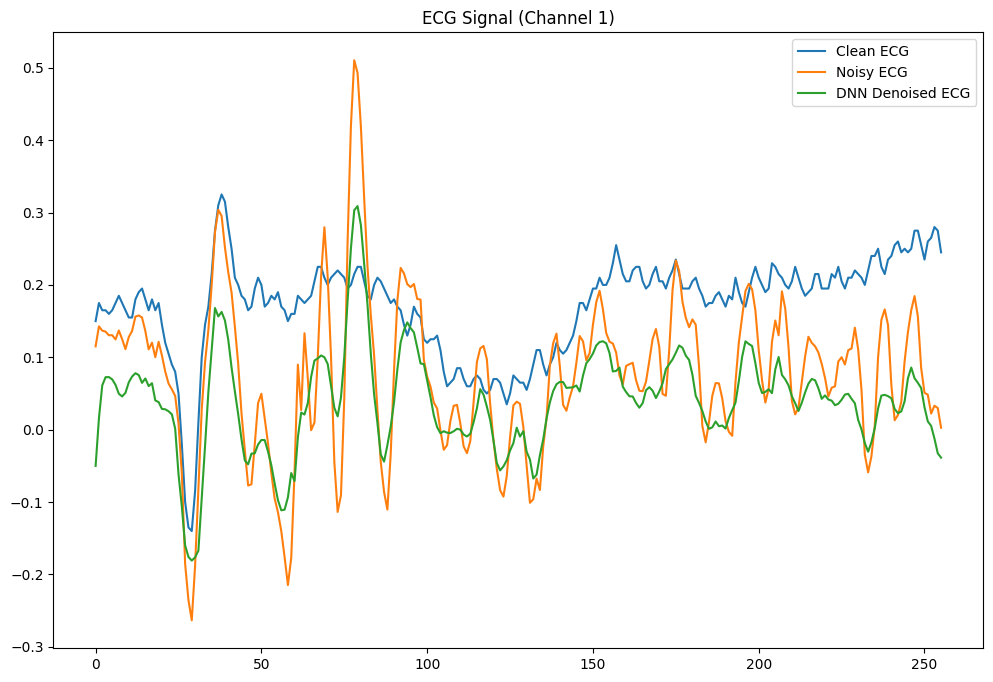

In [5]:
model = model_dict[model_name]()
model.load_state_dict(torch.load(f"./checkpoints/best_{model_name}_{noise_type}_snr_{snr_db}.pth", map_location="cpu"))
model.eval()

with torch.no_grad():
	noisy_input = torch.tensor(noisy)
	noisy_input = noisy_input.unsqueeze(0)  # Add batch dimension
	denoised_output = model(noisy_input)

clean_metric = torch.tensor(clean).unsqueeze(0)  # Add batch dimension
metrics_res = compute_metrics(denoised_output, clean_metric)
print("DNN Denoising Metrics:", metrics_res)

denoised_output = denoised_output.squeeze(0)  # Remove batch dimension

mean = np.array(mean).squeeze()
std = np.array(std).squeeze()
print(mean.shape, std.shape)

for i in range(denoised_output.shape[0]):
	denoised_output[i] = denoised_output[i] * std[i] + mean[i]
	clean[i] = clean[i] * std[i] + mean[i]
	noisy[i] = noisy[i] * std[i] + mean[i]


plt.figure(figsize=(12, 8))
plt.plot(clean[0], label="Clean ECG")
plt.plot(noisy[0], label="Noisy ECG")
plt.plot(denoised_output[0], label="DNN Denoised ECG")
plt.title("ECG Signal (Channel 0)")
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(clean[1], label="Clean ECG")
plt.plot(noisy[1], label="Noisy ECG")
plt.plot(denoised_output[1], label="DNN Denoised ECG")
plt.title("ECG Signal (Channel 1)")
plt.legend()

plt.show()